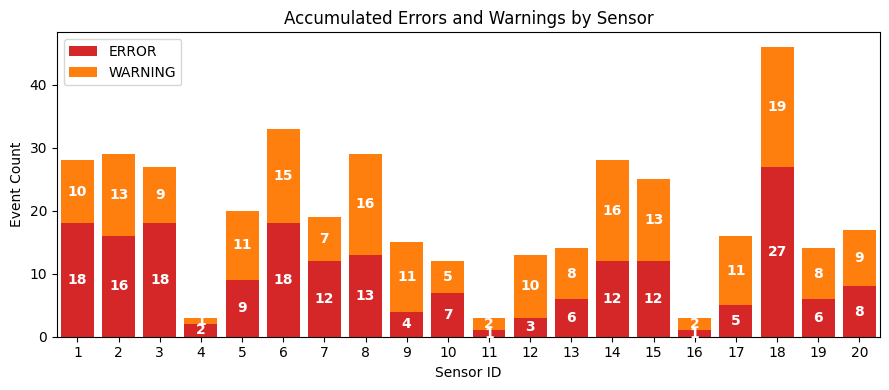

Stopped by user


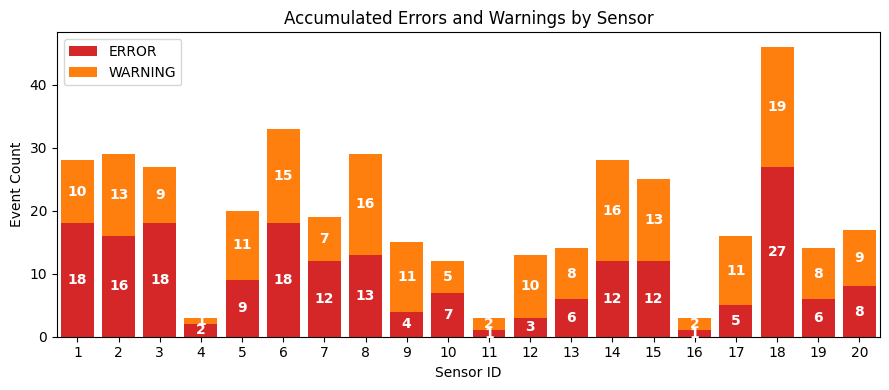

In [ ]:
import os
import json
import time
import logging
from collections import Counter

from confluent_kafka import Consumer, KafkaError, Message
from IPython.display import clear_output, display
import matplotlib.pyplot as plt

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Configuration (override via environment variables)
KAFKA_SERVERS = os.getenv("KAFKA_BOOTSTRAP_SERVERS", "localhost:9092")
KAFKA_TOPIC = os.getenv("KAFKA_TOPIC", "log-data")
CONSUMER_GROUP = os.getenv("CONSUMER_GROUP_ID", "log-vis-group")
POLL_TIMEOUT = float(os.getenv("POLL_TIMEOUT_SEC", "0.2"))
REFRESH_INTERVAL = float(os.getenv("REFRESH_INTERVAL_SEC", "1.0"))

# --- Functions ---
def create_consumer() -> Consumer:
    """
    Create and configure a Kafka consumer subscribed to the log-data topic.
    """
    conf = {
        "bootstrap.servers": KAFKA_SERVERS,
        "group.id": CONSUMER_GROUP,
        "auto.offset.reset": "latest",
        "enable.auto.commit": False
    }
    consumer = Consumer(conf)
    consumer.subscribe([KAFKA_TOPIC])
    logger.info("Subscribed to Kafka topic %s", KAFKA_TOPIC)
    return consumer


def process_message(msg: Message,
                    error_counts: Counter,
                    warning_counts: Counter) -> None:
    """
    Parse a Kafka message and update counters for ERROR and WARNING levels.
    """
    try:
        data = json.loads(msg.value())
        sensor_id = data.get("sensor_id")
        level = data.get("level")
        if not sensor_id or not level:
            return
        if level.upper() == "ERROR":
            error_counts[sensor_id] += 1
        elif level.upper() == "WARNING":
            warning_counts[sensor_id] += 1
    except json.JSONDecodeError:
        logger.warning("Invalid JSON received: %s", msg.value())


def update_plot(error_counts: Counter,
                warning_counts: Counter,
                fig: plt.Figure,
                ax: plt.Axes) -> None:
    """
    Redraw the bar chart to reflect current counts per sensor.
    """
    ax.clear()
    sensor_ids = sorted(
        set(error_counts) | set(warning_counts),
        key=lambda s: (error_counts[s] + warning_counts[s]),
        reverse=True
    )
    errs = [error_counts[s] for s in sensor_ids]
    warns = [warning_counts[s] for s in sensor_ids]

    ax.bar(sensor_ids, errs, label="ERROR")
    ax.bar(sensor_ids, warns, bottom=errs, label="WARNING")

    ax.set_xlabel("Sensor ID")
    ax.set_ylabel("Event Count")
    ax.set_title("Accumulated Errors and Warnings by Sensor")
    ax.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()

# --- Initialize consumer and counters ---
consumer = create_consumer()
error_counts = Counter()
warning_counts = Counter()

# --- Set up plot ---
fig, ax = plt.subplots(figsize=(10, 5))
last_refresh = time.time()

# --- Consumption loop ---
try:
    while True:
        msg = consumer.poll(POLL_TIMEOUT)
        if msg is None:
            pass
        elif msg.error():
            if msg.error().code() != KafkaError._PARTITION_EOF:
                logger.error("Kafka error: %s", msg.error())
        else:
            process_message(msg, error_counts, warning_counts)

        if time.time() - last_refresh >= REFRESH_INTERVAL:
            clear_output(wait=True)
            update_plot(error_counts, warning_counts, fig, ax)
            display(fig)
            last_refresh = time.time()

except KeyboardInterrupt:
    logger.info("Stopped by user")
finally:
    consumer.close()
    logger.info("Kafka consumer closed")
